In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../gpsims')

In [3]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [4]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [5]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.linear = nnx.Linear(width, width, rngs=rngs)
        # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
        # self.dropout = nnx.Dropout(0.2, rngs=rngs)
        self.linear_out = nnx.Linear(width, width, rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.linear(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.linear_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

    def __call__(self, x):
        return self.linear(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.ano2(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x

In [6]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)

In [67]:
def conv(x, k):
    return jnp.convolve(x, k, mode = 'valid')
conv = jit(vmap(conv, (0, None)))
kernel = jnp.ones(5)/5

rng0 = 100
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, 100)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)

xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest = conv(conv(xtest.squeeze(), kernel), kernel)

xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

In [68]:
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [69]:
# plt.plot(xtrain[0:10].squeeze().T)
# plt.show()

In [70]:
epochs = 100
trace = []
lag, lead = 1, 1

model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
quant = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
yval_hat = model(xval)
ytest_hat = model(xtest)
yval_quant = quant(xval)
ytest_quant = quant(xtest)

In [73]:
# nproj = 90
# gamma1 = 0.2
# alpha = 0.1
# nval = xval.shape[0]
# alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

In [74]:
yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
# pca_state = lsci.phi_state(yval, yval_hat, nproj)

In [75]:
# UQNO lambda estimate
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 100
tau = 1.1 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(0.0778855, dtype=float32)

In [76]:
nproj = 90
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

lsc1_rc = []
lsc2_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []

lsc1_width = []
lsc2_width = []
conf_width = []
supr_width = []
uqn1_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0]):
# for i in trange(0, 100):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma2, 2000)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.mean(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.mean(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [77]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = 0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [78]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 0.852 -0.568  1.285  0.   ]
 [ 0.888 -0.505  1.422  0.   ]
 [ 0.968 -0.297  1.602  0.182]
 [ 0.924 -0.013  0.912  0.928]
 [ 0.896 -0.035  0.876  0.926]]


In [79]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.852 & -0.568 & 1.285 & 0.000 \\
0.888 & -0.505 & 1.422 & 0.000 \\
0.968 & -0.297 & 1.602 & 0.182 \\
0.924 & -0.013 & 0.912 & 0.928 \\
0.896 & -0.035 & 0.876 & 0.926 \\


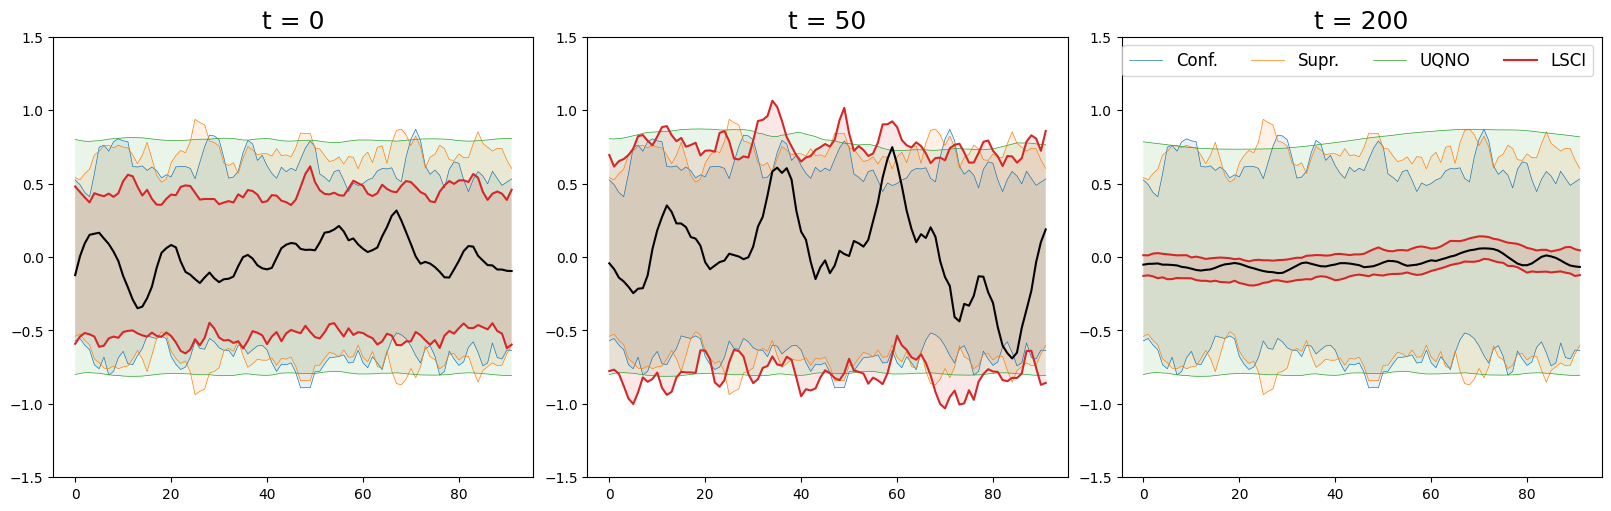

In [91]:
### examples
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 5))

n = [0, 50, 200]
s = np.arange(92)
for i in range(3):

    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n[i]], pca_state, alpha1, gamma1, 2000)
    uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n[i]]

    ax[i].set_ylim(-1.5, 1.5)
    ax[i].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
    ax[i].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
    ax[i].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
    ax[i].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
    ax[i].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
    ax[i].plot(uqno_lower, c = 'C2', lw = 0.5)
    ax[i].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
    ax[i].plot(lsc1_lower, c = 'C3', lw = 1.5)
    ax[i].plot(rtest[n[i]], c = 'black')
    
    ax[i].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
    
    ax[i].set_title(f't = {n[i]}', fontsize = 18)
ax[-1].legend(ncol = 4, fontsize = 12)

plt.show()

In [81]:
# plt.imshow(vp[0])
# plt.colorbar()

In [82]:
# u = swe.random_initial_condition()

# fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))
# ax[0].imshow(swe.isht(swe.timestep(u, 0))[0])
# ax[1].imshow(swe.isht(swe.timestep(u, 10))[0])
# ax[2].imshow(swe.isht(swe.timestep(u, 100))[0])

In [83]:
# plt.imshow(swe.isht(swe.timestep(u, 10))[0] - swe.isht(swe.timestep(u, 100))[0])
# plt.colorbar()